## 0.0. Dependencies and Data

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import math 
import rfpimp

In [129]:
retail_areas = pd.read_csv("retail_areas_final.csv")

In [130]:
print(retail_areas.dtypes)

date                                                       object
id                                                        float64
events                                                    float64
weekend                                                      bool
season                                                     object
holiday                                                      bool
Local Footprint Name                                       object
Region                                                     object
Base Score                                                float64
Retail Footprint Score                                    float64
Residential Population (Weighted Catchment)               float64
Spend Per Head (Residential)                              float64
Sparsity                                                   object
Longitude                                                 float64
Latitude                                                  float64
Tourism Sc

In [131]:
print("Number of unique Local_Footprint_Centre_ID:", retail_areas['Local_Footprint_Centre_ID'].nunique())
print("Total number of rows:", len(retail_areas))

Number of unique Local_Footprint_Centre_ID: 1207
Total number of rows: 437686


In [132]:
unique_days = retail_areas.loc[retail_areas['mean_wind'].isna(), 'date'].unique()
unique_days_sorted = sorted(unique_days)
print("Unique days with missing mean_wind:", unique_days_sorted)

Unique days with missing mean_wind: ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-25', '2024-02-09', '2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-10', '2024-03-11', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-23', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-07-05', '2024-07-06', '2024-07-07', '2024-08-05', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-28', '2024-08-29', '2024-08-30', '2024-08-31', '2024-09-01', '2024-09-02', '2024-09-03', '2024-09-11', '2024-10-07', '2024-10-12', '2024-10-13', '2024-10-30

## 1.1. Model Prep

### 1.1.1. Check for linear relationships

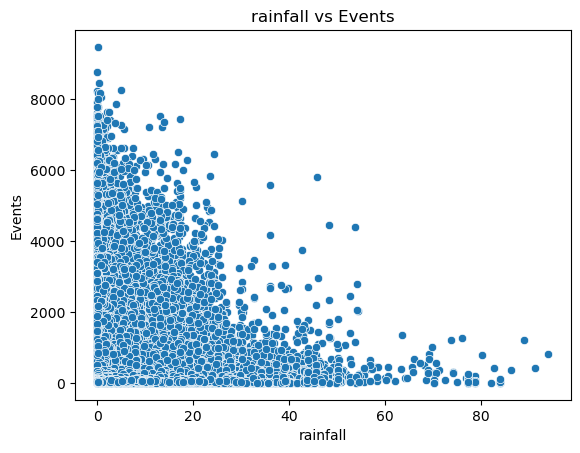

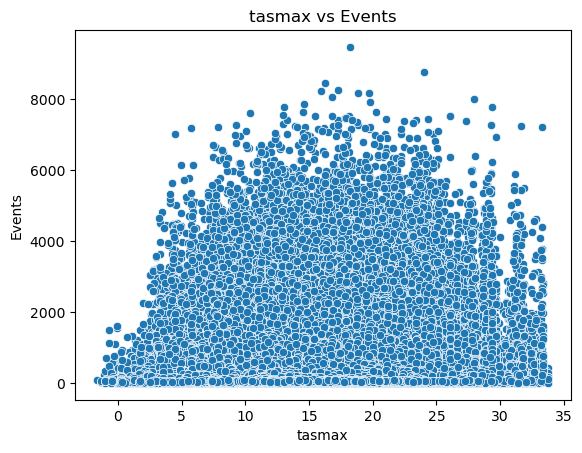

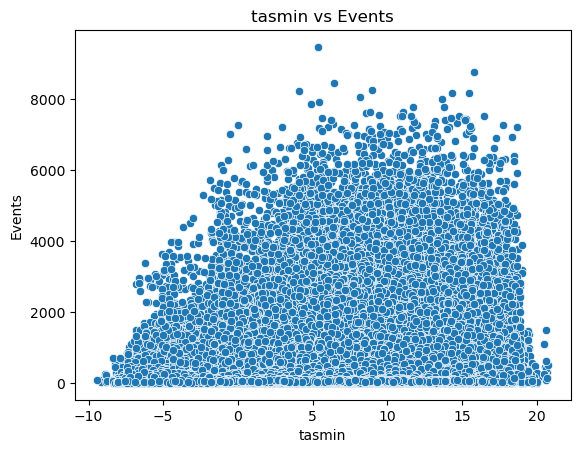

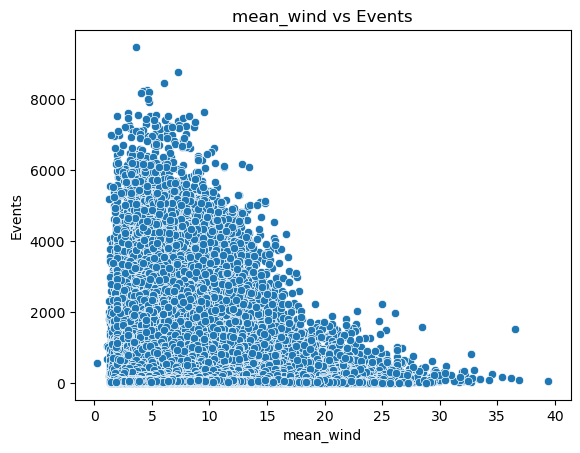

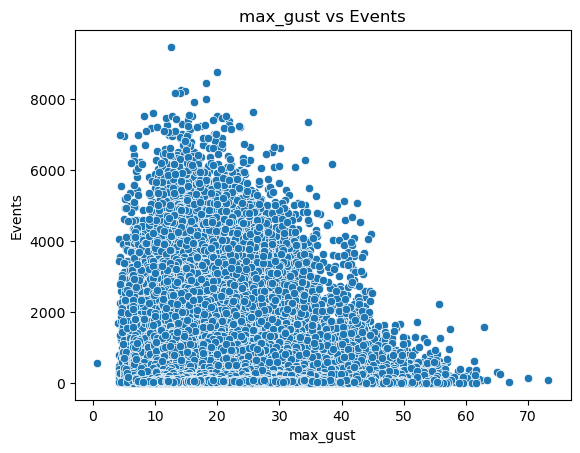

In [ ]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.scatterplot(x=var, y='events', data=retail_areas)
    plt.title(f'{var} vs Events')
    plt.xlabel(var)
    plt.ylabel('Events')
    plt.show()

### 1.1.2. Variable encoding

In [ ]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

# define weather variables
weather_vars = ['rainfall', 'tasmax', 'mean_wind']

# calculate mean annual footfall for each location
location_means = df_model.groupby('Local_Footprint_Centre_ID')['events'].mean().rename('location_mean_footfall')
# merge back to dataframe
df_model = df_model.merge(location_means, on='Local_Footprint_Centre_ID')

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score                680
Major_Class_Name             729
Minor_Class_Name             729
Seasonality_Class_Name       729
rainfall                    3976
tasmax                      3976
tasmin                      3976
mean_wind                 132578
max_gust                  132578
dtype: int64
Rows with at least one missing value: 136340
Total rows before drop: 437686
Total rows after drop: 301346


## 2.1. General Model

### 2.1.1. Most basic

Set up:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'weekend',
    'holiday',
    ] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1173
2024-01-16    1177
2024-01-17    1170
2024-01-18    1176
2024-01-19    1178
              ... 
2024-11-20    1181
2024-11-25    1182
2024-11-26    1179
2024-11-27    1184
2024-12-02    1181
Name: id, Length: 255, dtype: int64


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


Implement random forest:

In [ ]:
rf_final = RandomForestRegressor(**clf.best_params_, 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validate model performance:

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_final,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9433 ± 0.0005
Mean Train RMSE: 149.2983 ± 0.4014
Mean Test R²: 0.9362 ± 0.0025
Mean Test RMSE: 158.3274 ± 1.7036


Feature importance:

                                             Importance
Feature                                                
location_mean_footfall                         1.883288
season_Winter                                  0.045713
season_Spring                                  0.036854
Residential Population (Weighted Catchment)    0.013044
weekend                                        0.011797
season_Summer                                  0.008569
holiday                                        0.000787


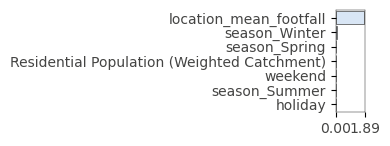

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 2.1.2. Add CACI scores

Set up:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=6; total time=  23.4s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  25.2s
[CV] END .................max_depth=10, min_samples_split=10; total time=  24.6s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  25.2s
[CV] END .................max_depth=10, min_samples_split=10; total time=  25.5s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  26.4s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  26.5s
[CV] END .................max_depth=10, min_samples_split=10; total time=  26.9s
[CV] END .................max_depth=10, min_samples_split=10; total time=  27.2s
[CV] END ..................max_depth=50, min_samples_split=8; total time=  28.5s
[CV] END ..................max_depth=50, min_samples_split=8; total time=  28.6s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  27.9s
[CV] END .................ma

Implement random forest:

In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validate model performance:

                                             Importance
Feature                                                
location_mean_footfall                         1.913666
season_Winter                                  0.043843
season_Spring                                  0.035419
weekend                                        0.017108
season_Summer                                  0.006749
Tourism Score                                  0.004973
Leisure_Footprint_Score                        0.003298
Residential Population (Weighted Catchment)    0.002339
holiday                                        0.001826
Retail Footprint Score                         0.001361


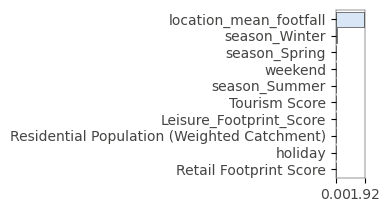

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 2.1.3. Add weather

Set up:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + weather_vars

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.1min
[CV] END .................ma

Implement random forest:

In [ ]:
rf_general_weather = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_general_weather.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validated performance:

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_general_weather,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9725 ± 0.0003
Mean Train RMSE: 103.9306 ± 0.2716
Mean Test R²: 0.9377 ± 0.0021
Mean Test RMSE: 156.4983 ± 1.5579


Feature importance:

                                             Importance
Feature                                                
location_mean_footfall                         1.843336
season_Spring                                  0.036969
season_Winter                                  0.031201
weekend                                        0.010947
tasmax                                         0.004170
Tourism Score                                  0.004134
mean_wind                                      0.003369
Leisure_Footprint_Score                        0.002841
season_Summer                                  0.001911
Retail Footprint Score                         0.001766
Residential Population (Weighted Catchment)    0.001213
holiday                                        0.001049
rainfall                                      -0.001703


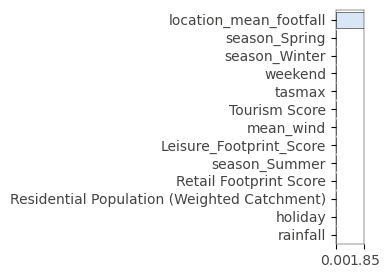

In [ ]:
imp = rfpimp.importances(rf_general_weather, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

Partial dependence plots:

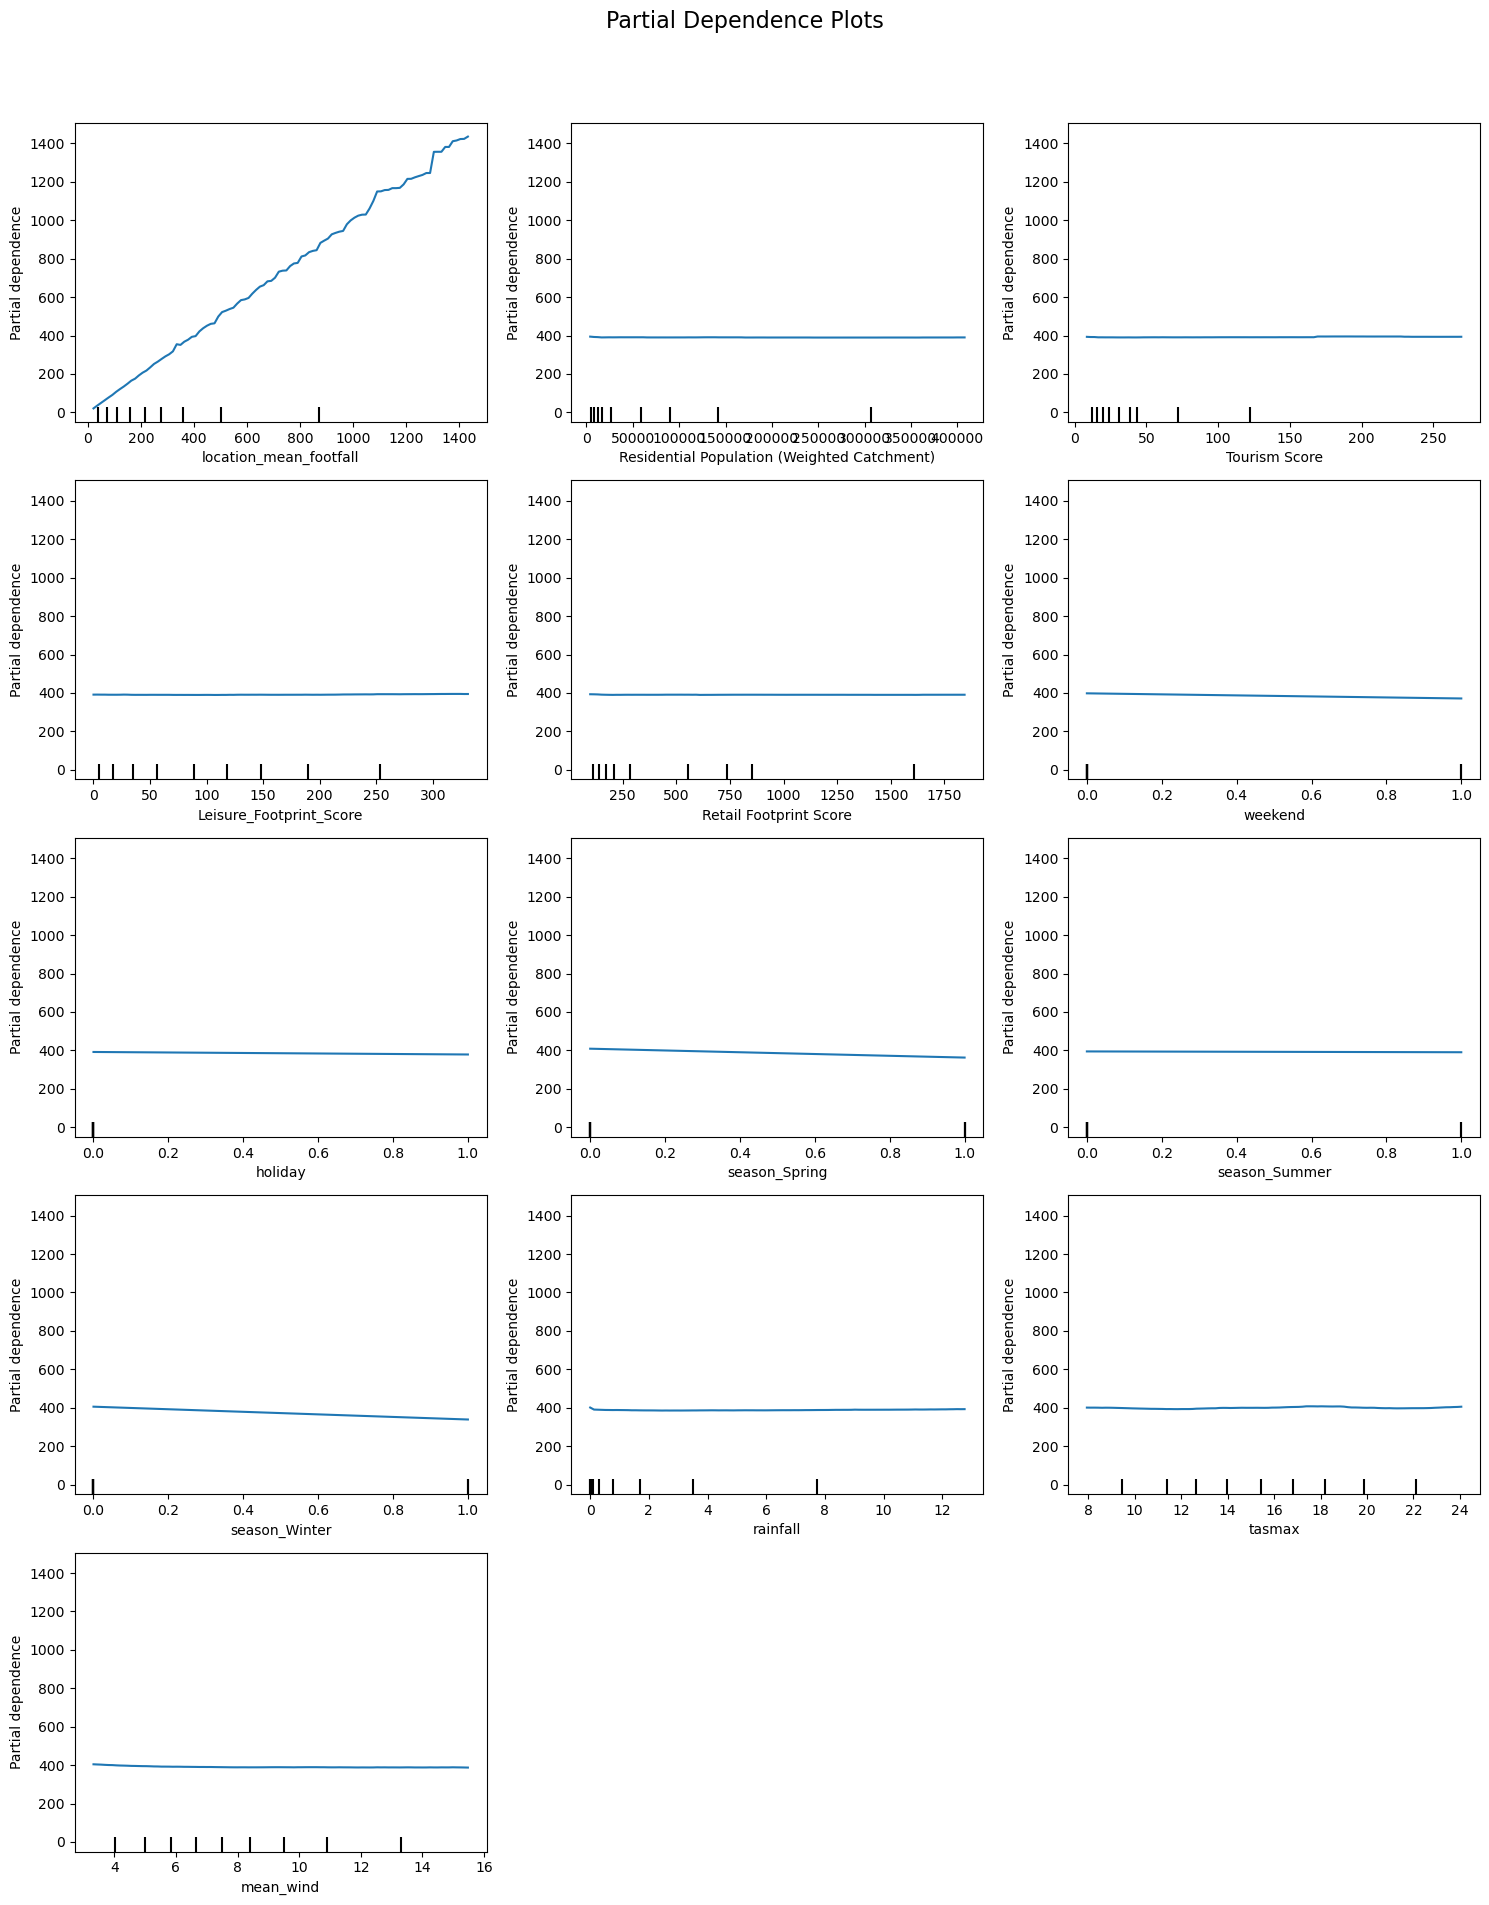

In [ ]:
# format plots output
features = train_x.columns.tolist()
n_features = len(features) 
n_cols = 3
n_rows = -(-n_features // n_cols)  # ceiling division

# create subplots
fig1, ax1 = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
ax1 = np.atleast_1d(ax1).flatten()

# plot PDPs
PartialDependenceDisplay.from_estimator(
    rf_general_weather,
    train_x,
    features=features,
    kind='average',     # PDP only
    centered=False,     # raw predictions
    ax=ax1[:n_features]
)

# remove empty subplots
for j in range(n_features, len(ax1)):
    fig1.delaxes(ax1[j])

plt.suptitle("Partial Dependence Plots", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 2.2. Model per retail type

### 2.2.1. With weather

In [ ]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'Tourism Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + weather_vars

Calibrated and cross-validated:

In [ ]:
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # split features/target
    X = group_data[features]
    y = group_data[target]

    # split into train/test
    train_x, test_x, train_y, test_y = train_test_split(
        X, y,
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {
        'max_depth': [10, 20, 30, 40, 50],
        'min_samples_split': [2, 4, 6, 8, 10]
    }
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    best_params = clf.best_params_
    print(f"\nGroup: {name}")
    print("Best parameters:", best_params)

    # cross-validation on full group
    model = RandomForestRegressor(random_state=randomState_dt, **best_params)
    cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

    cv_results = cross_validate(
        model,
        X, y,
        cv=cv_strategy,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error'
        },
        return_train_score=True,
        n_jobs=-1
    )

    # summarize CV metrics
    def summarize(metric):
        mean_val = np.mean(cv_results[f'train_{metric}'])
        std_val = np.std(cv_results[f'train_{metric}'])
        mean_test = np.mean(cv_results[f'test_{metric}'])
        std_test = np.std(cv_results[f'test_{metric}'])
        return mean_val, std_val, mean_test, std_test

    train_r2, std_train_r2, test_r2, std_test_r2 = summarize('r2')
    train_rmse, std_train_rmse, test_rmse, std_test_rmse = summarize('rmse')
    train_rmse, test_rmse = -train_rmse, -test_rmse  # invert negative RMSE

    print(f"Repeated CV (15-fold):")
    print(f"Train R²: {train_r2:.3f} ± {std_train_r2:.3f}")
    print(f"Train RMSE: {train_rmse:.3f} ± {std_train_rmse:.3f}")
    print(f"Test R²: {test_r2:.3f} ± {std_test_r2:.3f}")
    print(f"Test RMSE: {test_rmse:.3f} ± {std_test_rmse:.3f}")

    # final model for feature importances
    final_model = model.fit(train_x, train_y)
    importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)
    print("Feature Importances:")
    print(importances.round(3))

    # partial Dependence Plots for weather_vars
    X_weather = group_data[weather_vars].copy()
    model_weather = RandomForestRegressor(random_state=randomState_dt, **best_params).fit(X_weather, y)

    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    PartialDependenceDisplay.from_estimator(
        model_weather,
        X_weather,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # optional

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

KeyboardInterrupt: 

### 2.2.2 Extreme Weather

In [ ]:
# extreme weather dummies
df_model['extreme_heat'] = (df_model['tasmax'] > 30).astype(int)
df_model['extreme_rain'] = (df_model['rainfall'] > 25).astype(int)
df_model['high_wind'] = (df_model['mean_wind'] > 20).astype(int)

In [ ]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + [col for col in df_model.columns if col.startswith('season_')] + ['extreme_heat', 'extreme_rain', 'high_wind']

Calibrated and cross-validated:

In [ ]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)

    # fit tuned model on full group data (not just train_x/y)
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    )

    # repeated k-fold cross-validation
    cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    cv_results = cross_validate(
        model,
        group_data[features], group_data[target],
        cv=cv_strategy,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error'
        },
        return_train_score=True,
        n_jobs=-1
    )

    # summarize metrics
    mean_train_r2 = np.mean(cv_results['train_r2'])
    std_train_r2 = np.std(cv_results['train_r2'])

    mean_test_r2 = np.mean(cv_results['test_r2'])
    std_test_r2 = np.std(cv_results['test_r2'])

    mean_train_rmse = -np.mean(cv_results['train_rmse'])
    std_train_rmse = np.std(cv_results['train_rmse'])

    mean_test_rmse = -np.mean(cv_results['test_rmse'])
    std_test_rmse = np.std(cv_results['test_rmse'])

    print(f"Repeated CV (15-fold):")
    print(f"Train R²: {mean_train_r2:.3f} ± {std_train_r2:.3f}")
    print(f"Train RMSE: {mean_train_rmse:.3f} ± {std_train_rmse:.3f}")
    print(f"Test R²: {mean_test_r2:.3f} ± {std_test_r2:.3f}")
    print(f"Test RMSE: {mean_test_rmse:.3f} ± {std_test_rmse:.3f}")

    # fit final model for feature importances
    final_model = model.fit(train_x, train_y)
    importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)

    print("Feature Importances:")
    print(importances.round(3))


Group: District urban service centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.955
Repeated CV (15-fold):
Train R²: 0.960 ± 0.000
Train RMSE: 189.376 ± 0.898
Test R²: 0.955 ± 0.002
Test RMSE: 200.228 ± 3.738
Feature Importances:
location_mean_footfall                         0.953
season_Spring                                  0.011
season_Winter                                  0.010
Leisure_Footprint_Score                        0.006
weekend                                        0.006
Retail Footprint Score                         0.004
season_Summer                                  0.003
Residential Population (Weighted Catchment)    0.003
Tourism Score                                  0.002
holiday                                        0.001
extreme_rain                                   0.000
extreme_heat                                   0.000
high_wind                                      0.000
dtype: float64

Group: Indie high streets


Partial dependence plots:

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

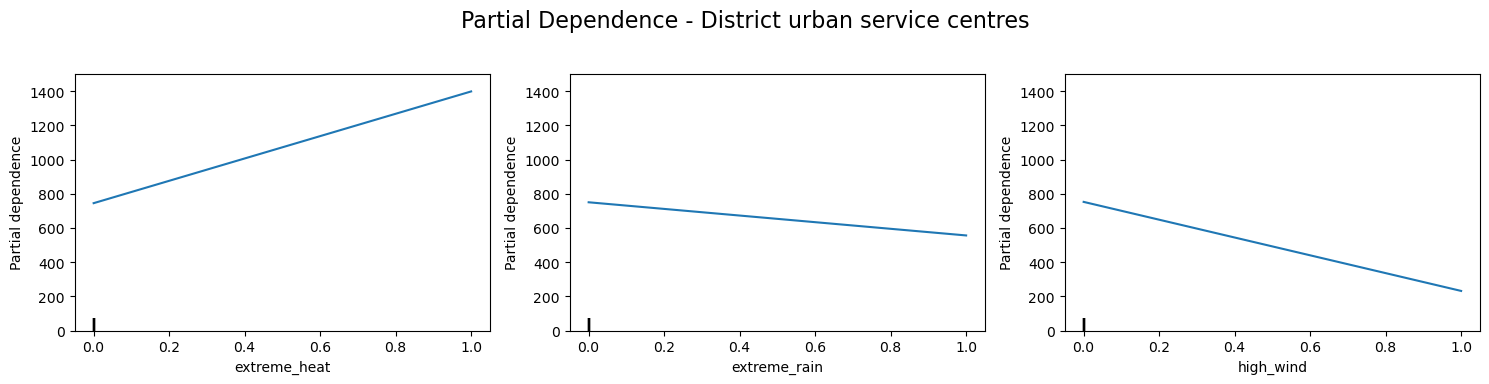

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

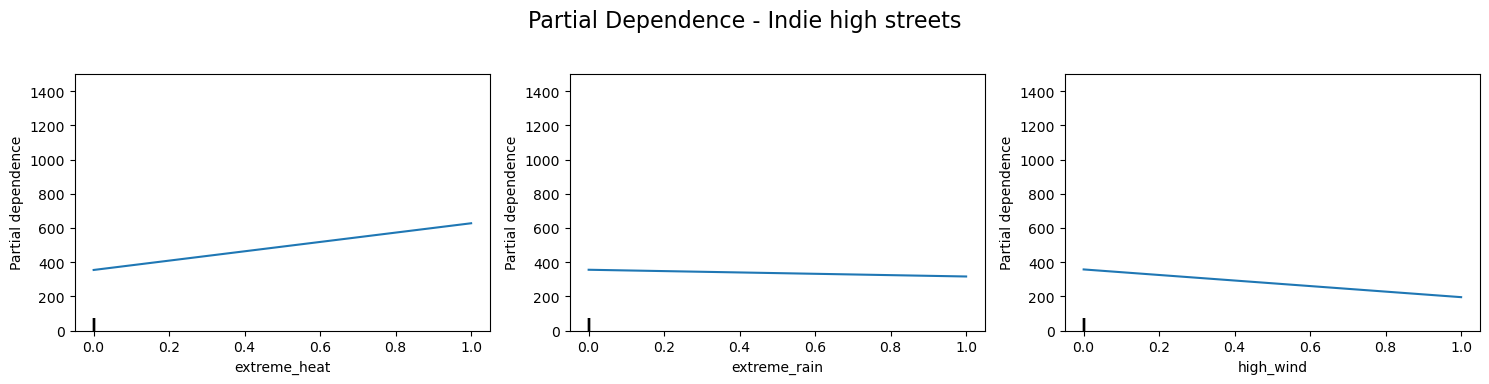

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

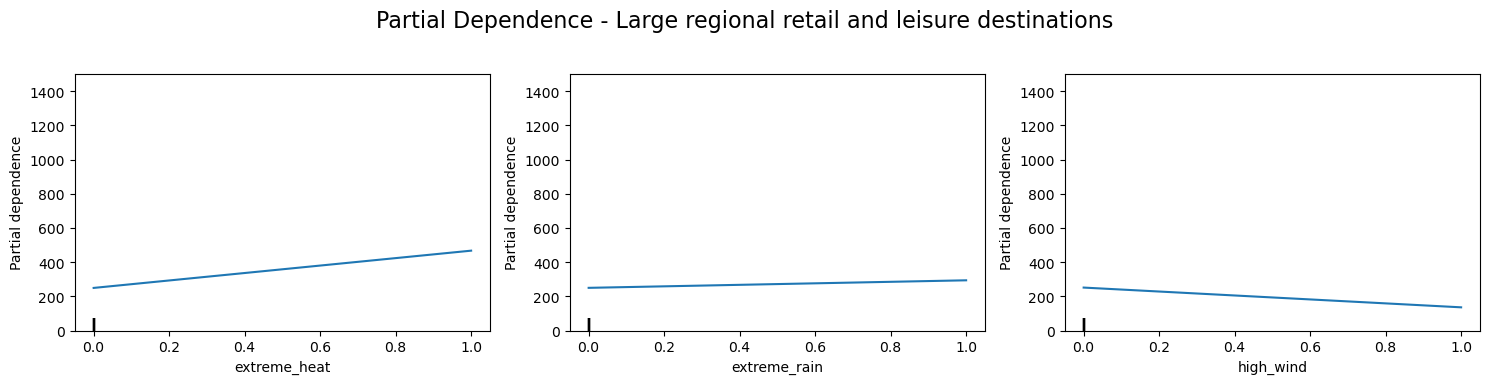

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

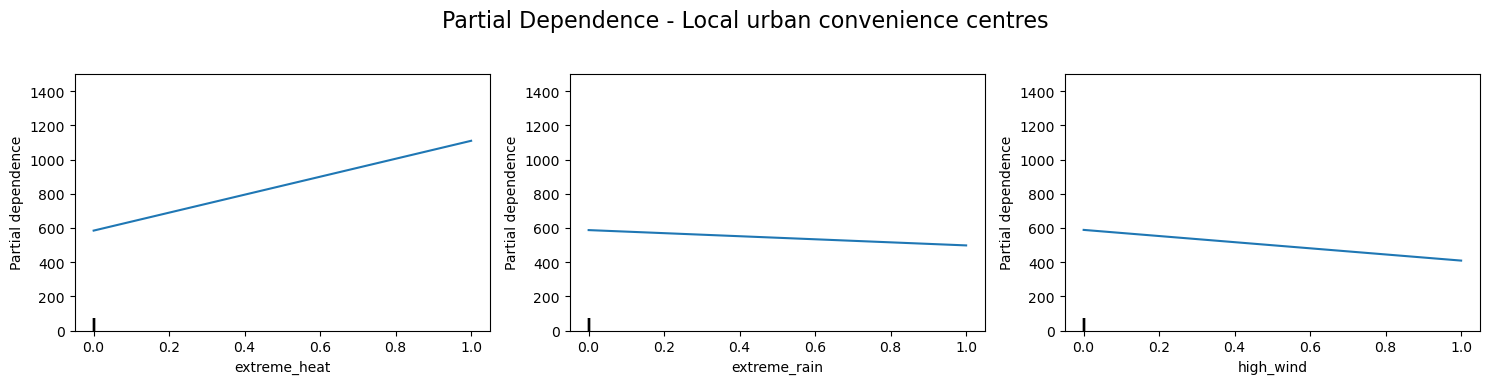

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

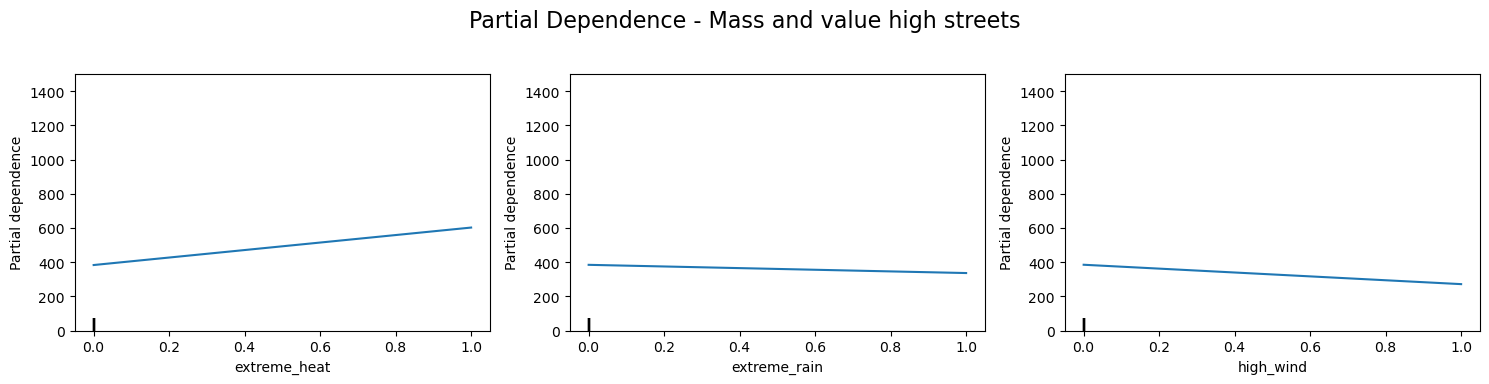

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

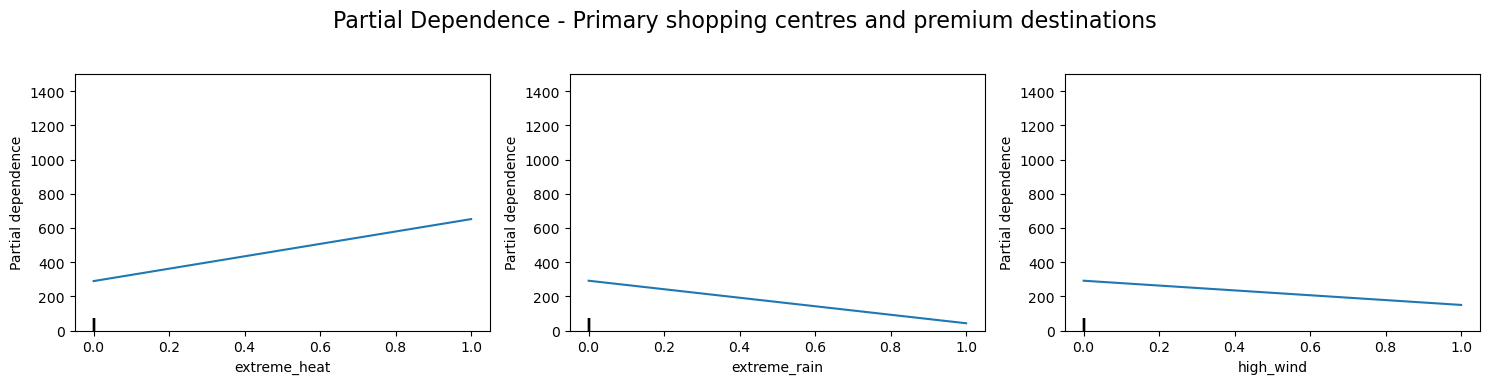

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

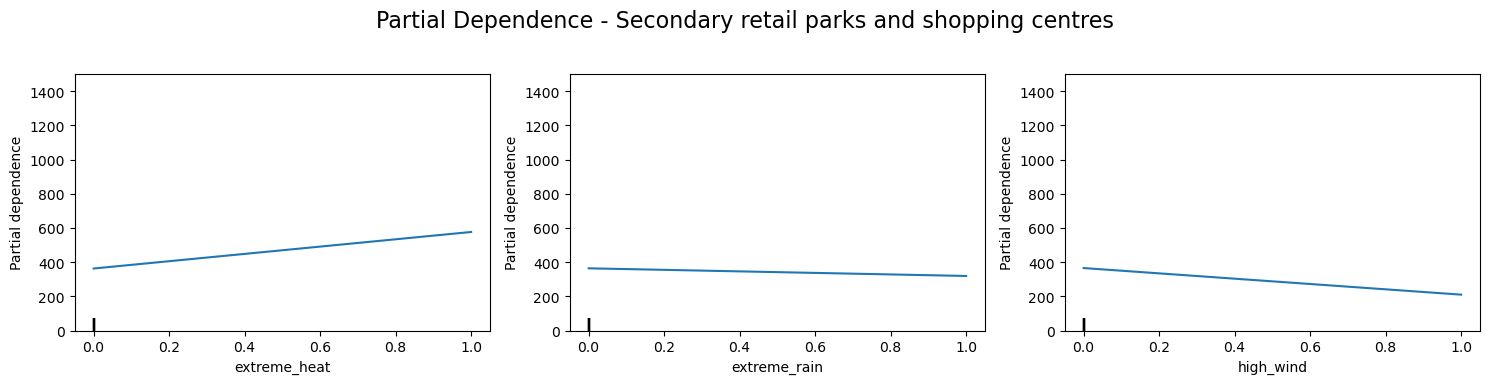

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependenc

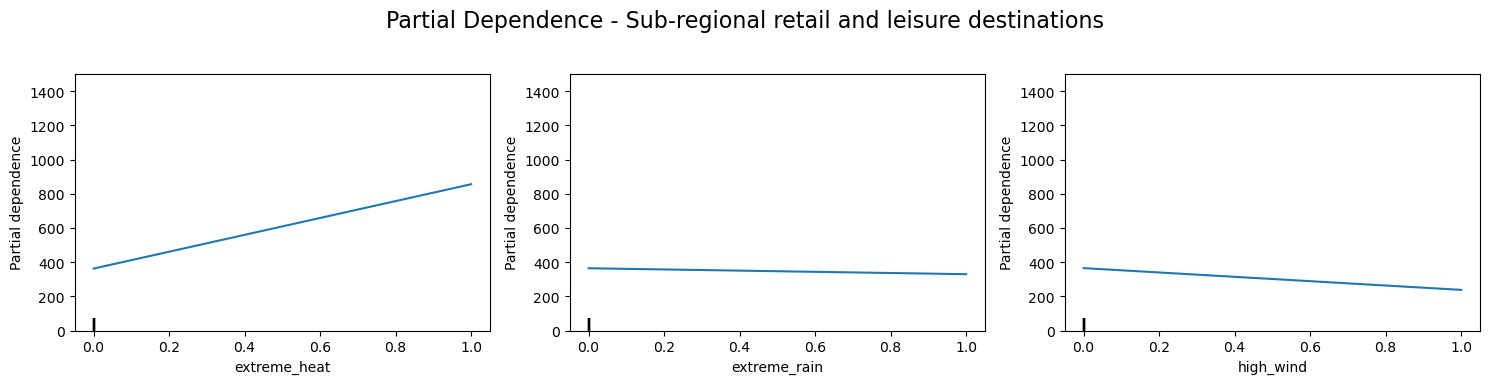

In [ ]:
weather_vars = ['extreme_heat', 'extreme_rain', 'high_wind']

for name, group_data in df_model.groupby('groupName'):
    if len(group_data) < 30:
        continue  # skip small groups

    X = group_data[weather_vars].copy()
    y = group_data['events']

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(X, y)

    # prepare layout
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    # plot partial dependence
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # optional: adjust y-limits for interpretability

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Old

In [ ]:
# define target and features
target = 'events'

# extreme weather dummies
df_model['extreme_heat'] = (df_model['tasmax'] > 30).astype(int)
df_model['extreme_rain'] = (df_model['rainfall'] > 25).astype(int)
df_model['high_wind'] = (df_model['mean_wind'] > 20).astype(int)

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + ['extreme_heat', 'extreme_rain', 'high_wind']

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=6; total time=  28.2s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  31.0s
[CV] END ..................max_depth=30, min_samples_split=4; total time=  30.5s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  31.8s
[CV] END .................max_depth=30, min_samples_split=10; total time=  30.3s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  32.2s
[CV] END ..................max_depth=30, min_samples_split=8; total time=  30.5s
[CV] END .................max_depth=30, min_samples_split=10; total time=  30.5s
[CV] END ..................max_depth=20, min_samples_split=8; total time=  31.1s
[CV] END ..................max_depth=20, min_samples_split=8; total time=  31.0s
[CV] END ..................max_depth=50, min_samples_split=4; total time=  30.4s
[CV] END ..................max_depth=30, min_samples_split=6; total time=  30.9s
[CV] END ..................m

In [ ]:
rf_extreme_weather = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_extreme_weather.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_extreme_weather,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9440 ± 0.0003
Mean Train RMSE: 148.2313 ± 0.2802
Mean Test R²: 0.9360 ± 0.0013
Mean Test RMSE: 158.4771 ± 1.1177


                                             Importance
Feature                                                
location_mean_footfall                         1.879771
season_Winter                                  0.040144
season_Spring                                  0.036832
weekend                                        0.013014
Leisure_Footprint_Score                        0.005819
season_Summer                                  0.005717
Tourism Score                                  0.003666
holiday                                        0.001105
Retail Footprint Score                         0.000600
Residential Population (Weighted Catchment)    0.000129
extreme_rain                                  -0.000030
high_wind                                     -0.000058
extreme_heat                                  -0.000121


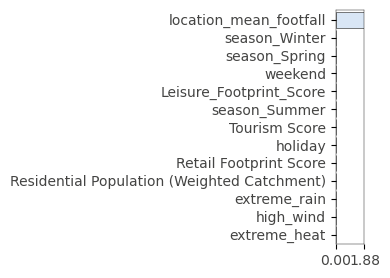

In [ ]:
imp = rfpimp.importances(rf_extreme_weather, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### Add retail type

Get retail type dummies:

In [ ]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# drop unnecessary columns
df_model = df_model.drop(['Minor_Class_Name', 'Major_Class_Name', 'Seasonality_Class_Name'], axis=1)

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region', 'groupName', 'supergroupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

# calculate mean annual footfall for each location
location_means = df_model.groupby('Local_Footprint_Centre_ID')['events'].mean().rename('location_mean_footfall')

# merge it back to your dataframe
df_model = df_model.merge(location_means, on='Local_Footprint_Centre_ID')

# extreme weather dummies
df_model['extreme_heat'] = (df_model['tasmax'] > 30).astype(int)
df_model['extreme_rain'] = (df_model['rainfall'] > 25).astype(int)
df_model['high_wind'] = (df_model['mean_wind'] > 20).astype(int)

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score       680
rainfall           3976
tasmax             3976
tasmin             3976
mean_wind        132578
max_gust         132578
dtype: int64
Rows with at least one missing value: 135831
Total rows before drop: 437686
Total rows after drop: 301855


Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'location_mean_footfall',
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_') or col.startswith('groupName_')] + ['extreme_heat', 'extreme_rain', 'high_wind']

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END .................max_depth=10, min_samples_split=10; total time=  26.4s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  29.0s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  29.7s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  30.0s
[CV] END .................max_depth=10, min_samples_split=10; total time=  29.6s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  32.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  35.0s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  36.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  36.0s
[CV] END .................max_depth=20, min_samples_split=10; total time=  34.7s
[CV] END .................max_depth=20, min_samples_split=10; total time=  34.9s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  36.5s
[CV] END ..................m

Implement random forest:

In [ ]:
rf_retail2 = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_retail2.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validated performance:

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained rf_retail2 model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_retail2,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_r2 = np.mean(cv_results['test_r2'])
std_r2 = np.std(cv_results['test_r2'])

mean_rmse = -np.mean(cv_results['test_rmse'])  # negate because it's negative by default
std_rmse = np.std(cv_results['test_rmse'])

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9440 ± 0.0003
Mean Train RMSE: 148.2348 ± 0.2792
Mean Test R²: 0.9360 ± 0.0013
Mean Test RMSE: 158.4842 ± 1.1040


Feature importance:

                                                    Importance
Feature                                                       
location_mean_footfall                                1.790734
season_Winter                                         0.050824
season_Spring                                         0.038346
weekend                                               0.012156
season_Summer                                         0.007309
Leisure_Footprint_Score                               0.004230
Residential Population (Weighted Catchment)           0.003129
holiday                                               0.001924
Tourism Score                                         0.001643
Retail Footprint Score                                0.001207
groupName_Indie high streets                          0.000555
groupName_Large regional retail and leisure des...    0.000347
groupName_Local urban convenience centres             0.000231
groupName_Mass and value high streets                 0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


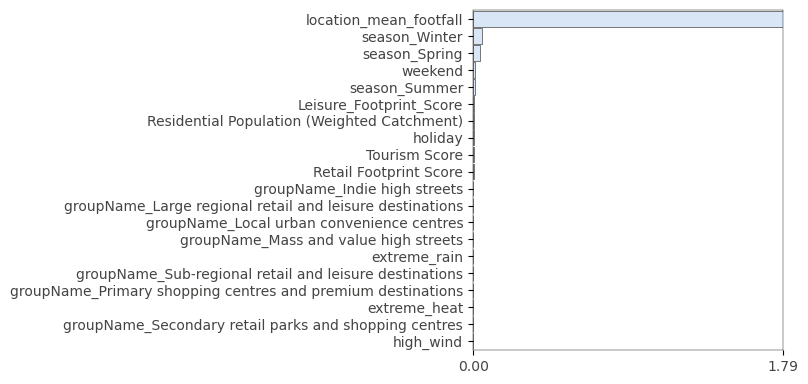

In [ ]:
imp = rfpimp.importances(rf_retail2, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

Partial dependence plot:

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 17 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 18 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_depende

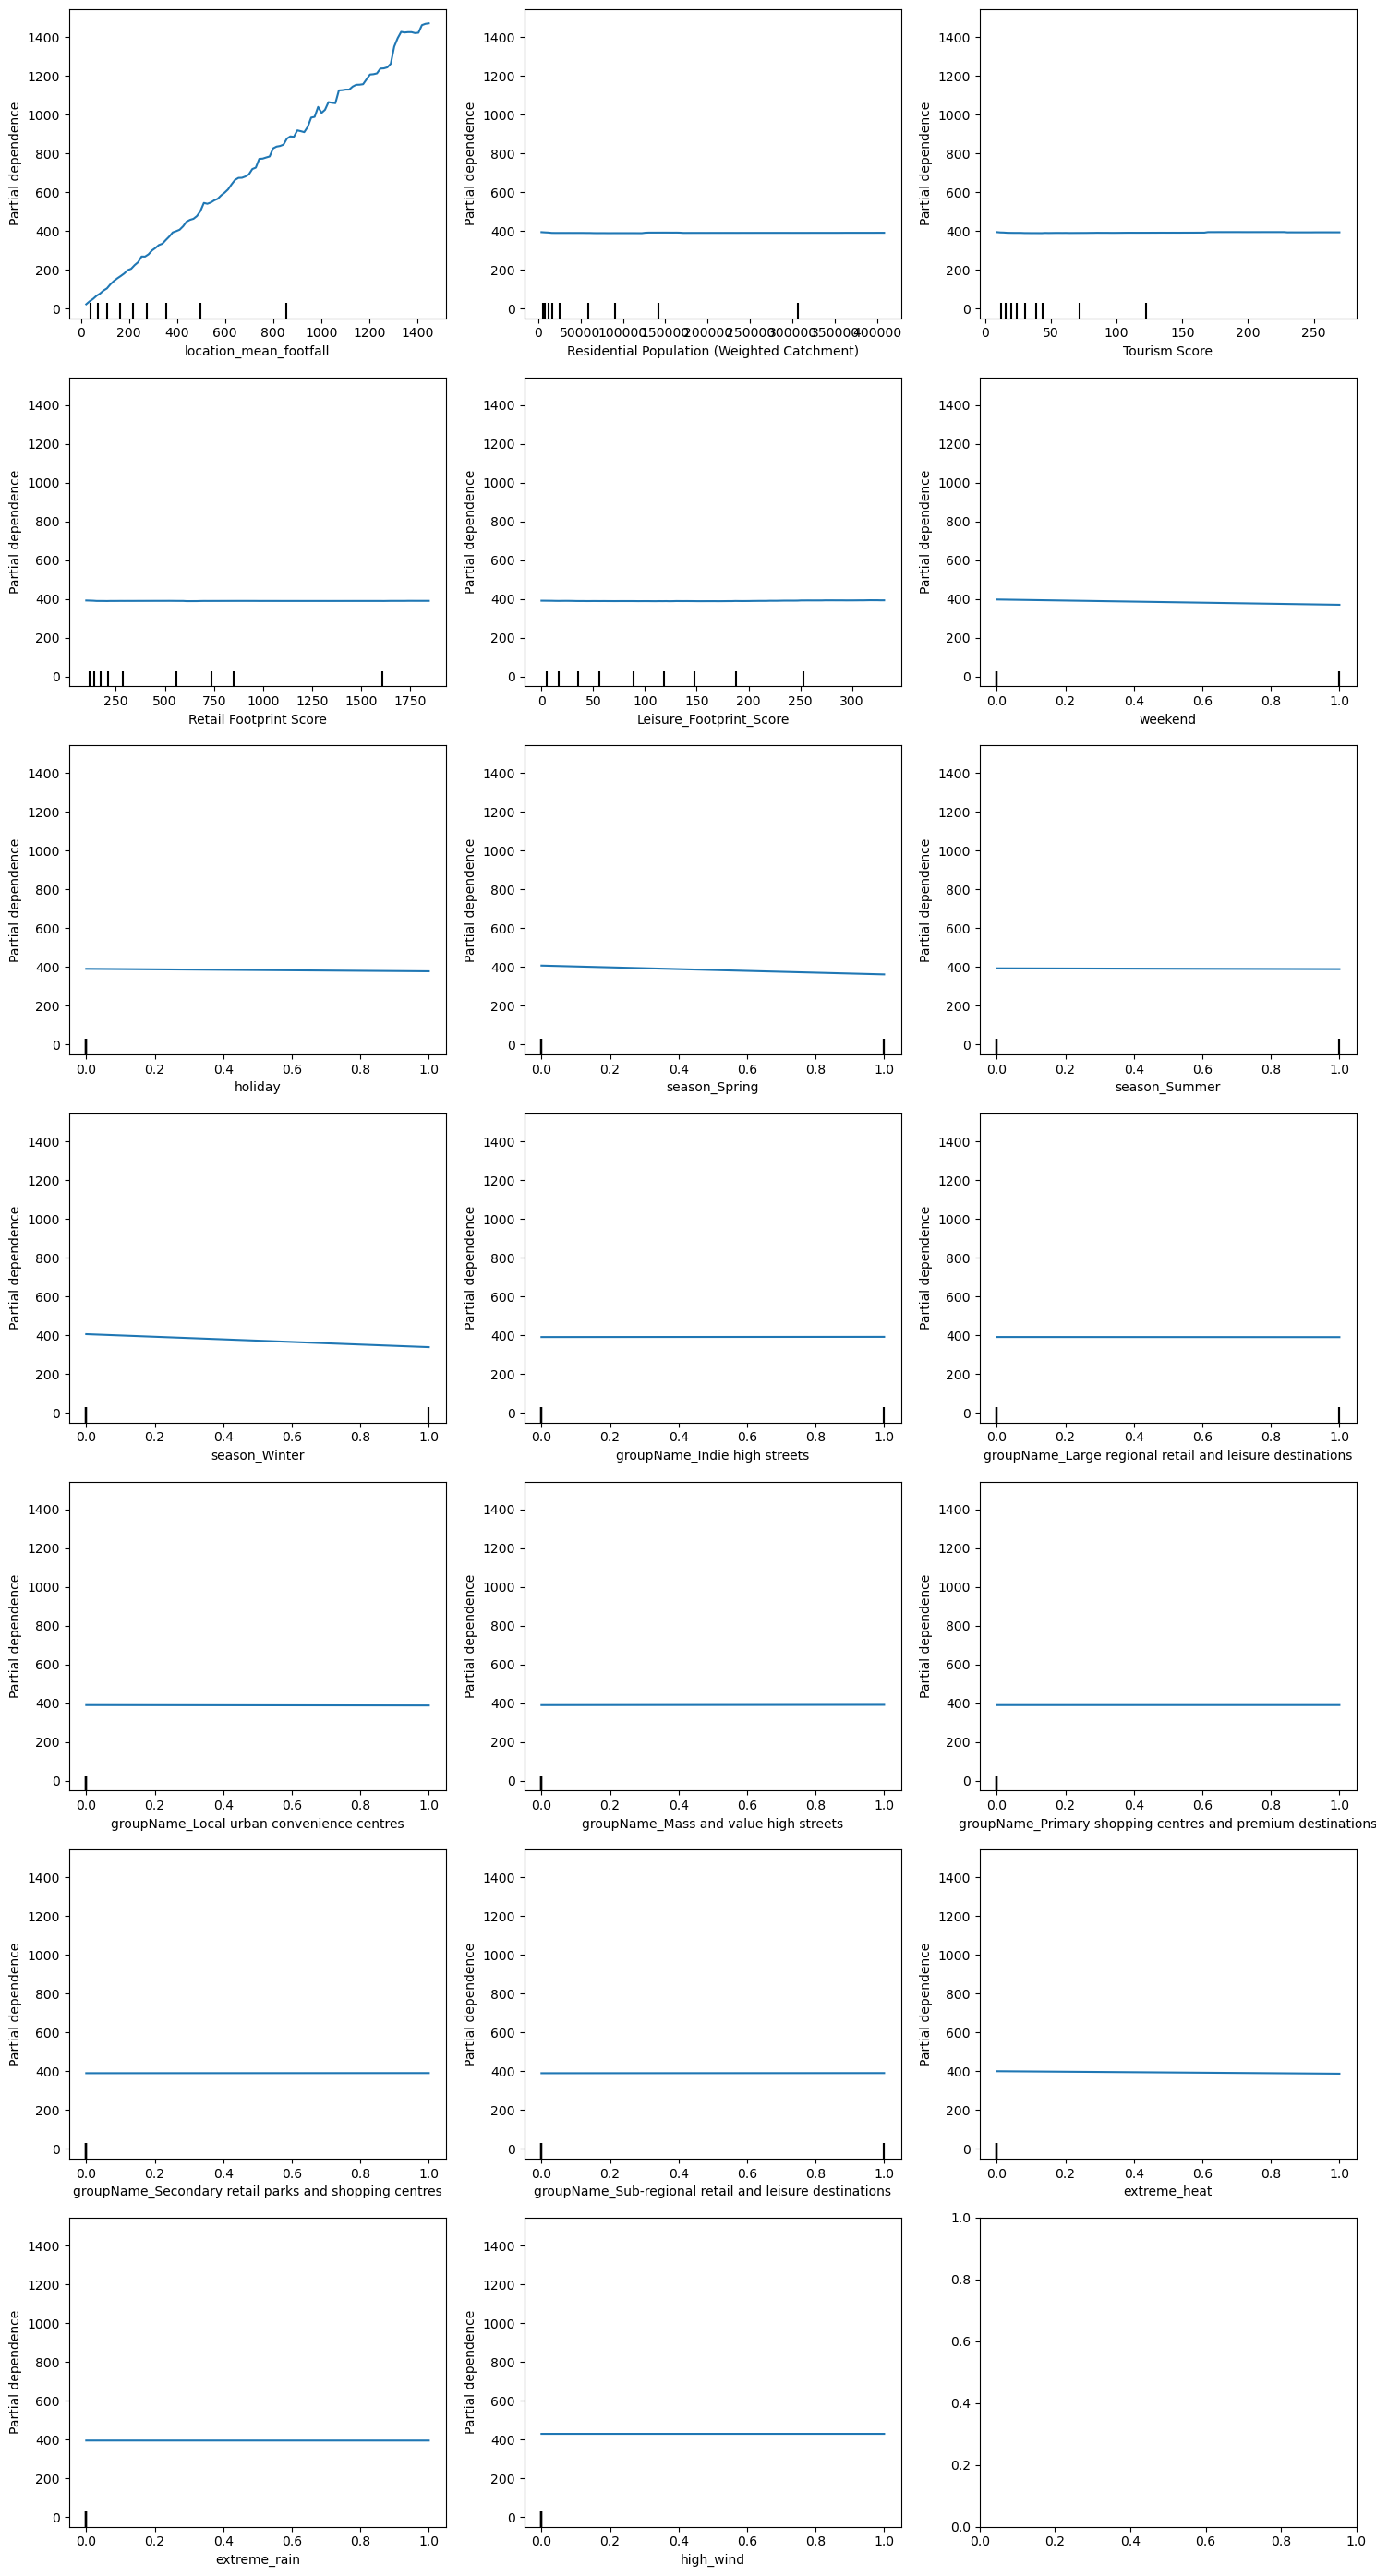

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# plot partial dependence for all features in train_x
features = train_x.columns.tolist() 

# create grid layout
n_features = len(features)
n_cols = 3
n_rows = -(-n_features // n_cols)  # ceiling division

fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
ax = ax.flatten()

# plot
PartialDependenceDisplay.from_estimator(
    rf_retail,
    train_x,
    features=features,
    ax=ax[:n_features]  # ensure ax isn't longer than the number of features
)

plt.tight_layout()
plt.show()